## Import, Connect

In [205]:
from datetime import datetime as datetm,timedelta
import rethinkdb as r                                # http://rethinkdb.com/api
import pandas as pd, numpy as np                     # http://pandas.pydata.org/pandas-docs/version/0.18.1/index.html
%pylab inline
import seaborn as sns                                # https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.factorplot.html#seaborn.factorplot                                
from aclib.func4strings import Func4strings as f4s

rdb = r.connect(host='127.0.0.1', db='hdh') ; rdb.use('hdh')  # print('Bases = %s' % str(r.db_list().run(rdb)))

Populating the interactive namespace from numpy and matplotlib


## Nombre de nouvelles annonces par jour

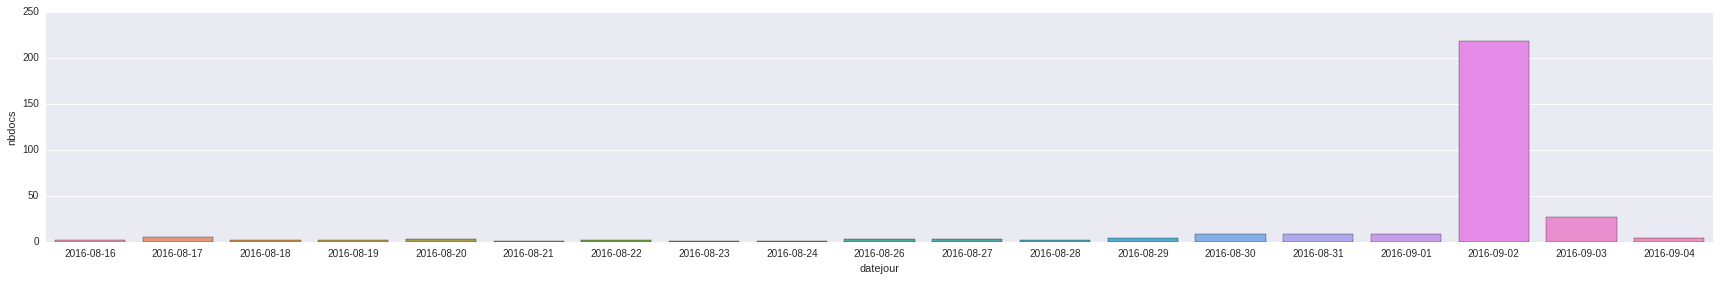

In [207]:
nb_days_history = 20
DateMax  = r.table('immoanno')['ts_updated'].max().run(rdb)
DateLimite = DateMax - timedelta(days=int(nb_days_history))

# modif de chaque obj par creation d'un objet a partir de chaque objet de la table grace a object() qui est map() a toute la table puis merge()
# l'objet cree ne contient qu'une date tronque au jour par slice(), ensuite group() par le champ et count()
distri_date = r.table('immoanno').filter(lambda row : row["ts_updated"].ge(DateLimite)).map(lambda val: val.merge(r.object('ts_updated_group', val['ts_updated'].to_iso8601().slice(0,10)))).group('ts_updated_group').count().run(rdb) 
distri_date_df = pd.DataFrame(columns=['datejour', 'nbdocs'], data={'datejour': list(distri_date.keys()), 'nbdocs': list(distri_date.values())})
df_to_show = distri_date_df.sort_values(by='datejour', ascending=True, inplace=False, kind='quicksort', na_position='last')

# https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.factorplot.html#seaborn.factorplot
sns.set_style('darkgrid')
sns.factorplot(data=df_to_show, x='datejour', y='nbdocs', kind="bar", aspect=6.0, order=list(df_to_show.datejour))

## Nombre de nouvelles annonces par site

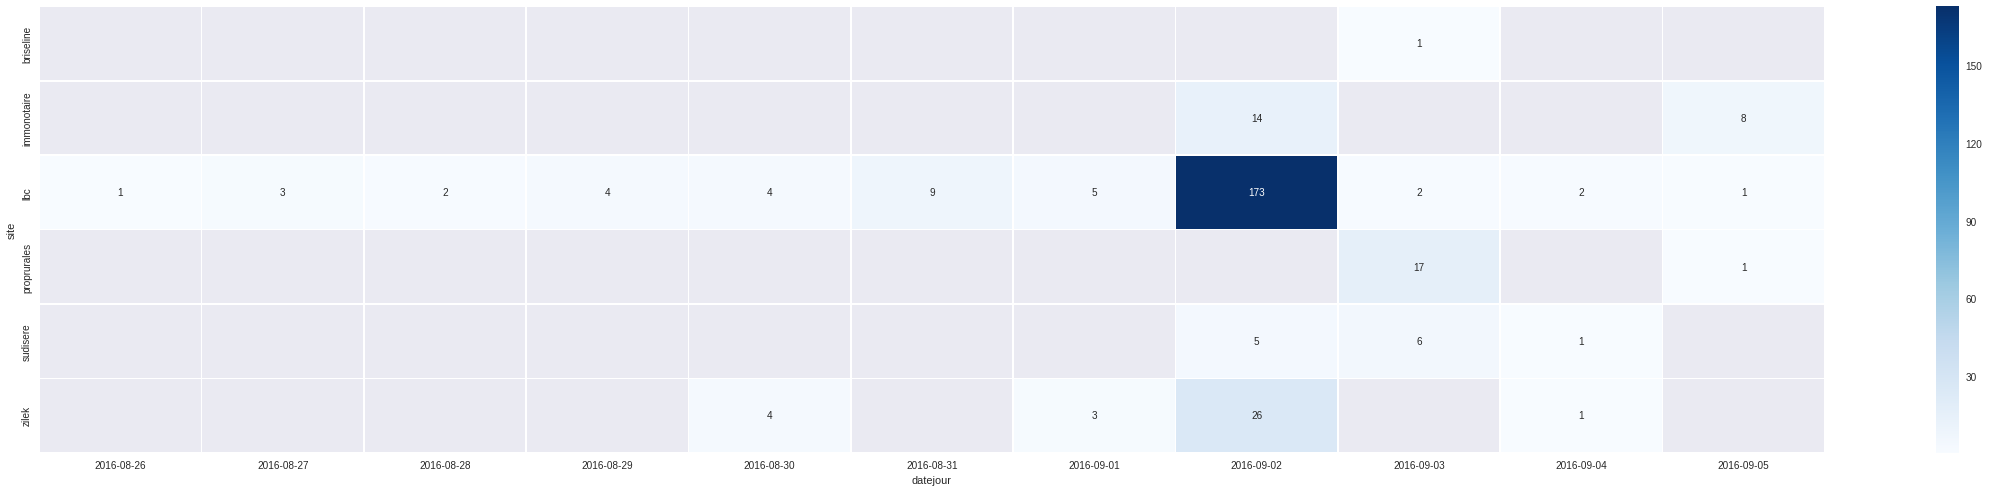

In [266]:
nb_days_history = 10
DateMax  = r.table('immoanno')['ts_updated'].max().run(rdb)
DateLimite = DateMax - timedelta(days=int(nb_days_history))

list_sources = r.table('immoanno')['sources'].distinct().reduce(lambda left,right : left+right).distinct().run(rdb)
list_sources_sites = ['briseline', 'immonotaire', 'proprurales', 'lbc', 'sudisere', 'zilek']

liste_stats = []
for lesite in list_sources_sites :
    curseur = r.table('immoanno').filter(lambda row : row["ts_updated"].ge(DateLimite))
    curseur = curseur.filter(r.row['sources'].contains(lesite))
    curseur = curseur.map(lambda val: { 'site' : lesite , 'date' : val['ts_updated'].to_iso8601().slice(0,10) }).group('date').count()
    g = curseur.run(rdb)
    for k in sorted(g.keys()) : 
        liste_stats.append([k, lesite, int(g[k])])

immostat = pd.DataFrame(data=liste_stats, columns=['datejour', 'site', 'updates'])
immostat.head()
immostat2 = immostat.pivot("site", "datejour", "updates")

# https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html#seaborn.heatmap
# color maps : http://matplotlib.org/examples/color/colormaps_reference.html
sns.set_style('darkgrid')
plt.figure(figsize=(40, 8))
sns.heatmap(immostat2, annot=True, robust=False, fmt=".0f", linewidths=.5, cmap='Blues')  # cmap='jet' 'YlGnBu'

In [ ]:
# http://influxdb-python.readthedocs.io/en/latest/

from influxdb import InfluxDBClient
idbc = InfluxDBClient('127.0.0.1', 8086, username='idbagent', password='706MsDD4', database='hdhmon', timeout=20)
#result = idbc.query("SELECT SUM(value) FROM number WHERE time >= now() - 1w AND app_uname = 'fetcher.immo' AND (number_of = 'annonces_discarded' OR number_of = 'annonces_anomaly') GROUP BY number_of,time(1d) ;")
result = idbc.query("SELECT * FROM number WHERE time >= now() - 1w AND app_uname = 'fetcher.immo' ;")


In [ ]:
import requests
url_query = 'http://localhost:8086/query?pretty=true' --data-urlencode "db=mydb" --data-urlencode "q=SELECT value FROM cpu_load_short WHERE region='us-west'"

# https://docs.influxdata.com/influxdb/v0.13/guides/querying_data/
# https://docs.influxdata.com/influxdb/v0.13/query_language/functions/

reqi = requests.get(url_query, timeout=20)



In [246]:
# print(r.table('immoanno')['sources'].distinct().reduce(lambda left,right : left+right).distinct().run(rdb))
tag_original = 'immo-notaires'
tag_new_name = 'immonotaire'
curseur = r.table('immoanno').filter(lambda obj : obj["sources"].contains(tag_original))
curseur = curseur.update({'sources' : r.row["sources"].difference([tag_original]).append(tag_new_name) })
curseur.run(rdb)



{'deleted': 0,
 'errors': 0,
 'inserted': 0,
 'replaced': 14,
 'skipped': 0,
 'unchanged': 0}

In [247]:
r.table('immoanno')['sources'].distinct().reduce(lambda left,right : left+right).distinct().run(rdb)

['aiguebelette.73610',
 'bauges.73630',
 'belledonne.73110',
 'belledonne.73220',
 'briseline',
 'diois.26410',
 'ecrins.38520',
 'immonotaire',
 'lbc',
 'monteynard.38350',
 'monteynard.38650',
 'monteynard.38930',
 'monteynard.roissard',
 'monteynard.saintmartin',
 'monteynard.saintmichel',
 'proprurales',
 'sudisere',
 'trieves.38710',
 'trieves.38930',
 'zilek']

## Query : Nb de docs par jour sur un field timestamp

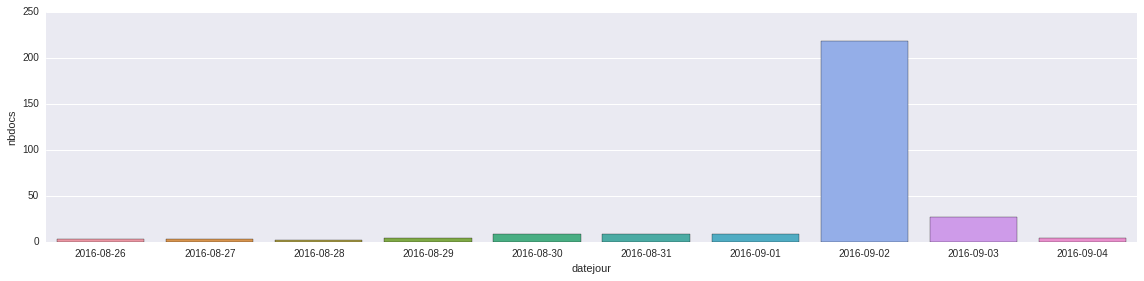

In [194]:
#list(r.table('immoanno').get_field('ts_updated').map(lambda val: val.to_iso8601().slice(0,10)).group('ts_updated').count().limit(10).run(rdb))

distri_date = r.table('immoanno').map(lambda val: val.merge(r.object('ts_updated_group', val['ts_updated'].to_iso8601().slice(0,10)))).group('ts_updated_group').count().run(rdb) 
#distri_date_df = pd.DataFrame(index=distri_date.keys(), columns=['nbdocs'], data=list(distri_date.values()))

distri_date_df = pd.DataFrame(columns=['datejour', 'nbdocs'], data={'datejour': list(distri_date.keys()), 'nbdocs': list(distri_date.values())})
df_to_show = distri_date_df.sort_values(by='datejour', ascending=True, inplace=False, kind='quicksort', na_position='last')
df_to_show = df_to_show[-10:]
sns.factorplot(data=df_to_show, x='datejour', y='nbdocs', kind="bar", aspect=4.0, order=list(df_to_show.datejour))
#distri_date_df

In [53]:
objs = list(r.table('immoimg').run(rdb))
print("Nb img total = %d" % len(objs))
images_sans_annonces = 0
for obj in objs :
    if r.table('immoanno').get(obj['annonce_id']).run(rdb) is None :
        r.table('immoimgDiscarded').insert(obj).run(rdb)
        r.table('immoimg').get(obj['id']).delete().run(rdb)
        images_sans_annonces += 1
print("Nb img orphelines deplacees = %d" % images_sans_annonces)

Nb img total = 5719
Nb img orphelines deplacees = 1332


In [51]:
z = r.table('immoanno').get('fdgdfg').run(rdb)
type(z)

NoneType

## Deplacer des items dont un champ fait partie d'une liste

In [45]:
from aclib.func4strings import Func4strings as f4s
liste_villes_exclure = ['aix les bains', '73100', 'auris', '38142', 'bernin', '38190', 'chambery', '38000', 'grenoble', '73000', 'charvieu chavagneux', 'huez', '38750', 'bourg d oisans', 'livet et gavet', 'montmelian']

objs = list(r.table('immoanno').run(rdb))
nb_anno_discarded = 0
for obj in objs :
    if f4s.strMatchAny(liste_villes_exclure, obj['localite_stz']) or f4s.strMatchAny(liste_villes_exclure, obj['codepostal']):
        r.table('immoannoDiscarded').insert(obj).run(rdb)
        r.table('immoanno').get(obj['id']).delete().run(rdb)
        nb_anno_discarded += 1
nb_anno_discarded

173

In [32]:
for obj in objs :
    obj['localite_stz'] = obj['localite_stz'].replace("-", " ")
    r.table('immoanno').get(obj['id']).update({'localite_stz' : r.row['localite_stz'].downcase()}).run(rdb)

In [35]:
r.table('immoanno').update({'localite_stz' : r.row['localite_stz'].downcase()}).run(rdb)

{'deleted': 0,
 'errors': 0,
 'inserted': 0,
 'replaced': 417,
 'skipped': 0,
 'unchanged': 541}

## Query : rowcount of tables

In [267]:
#-- Query RDB de rowcount de tables dans un DataFrame (format un peu special renvoye par RDB)
# tables_par_row = r.table_list().map(lambda val:[val,r.table(val).count()]).run(rdb) # [['tableX', count], ['tblY', count]]
#-- Query RDB de rowcount de tables dans un DataFrame (format en model list of dict, comme du json)
tables_par_row = r.table_list().map(lambda val: {'tablename':val, 'nbdocs':r.table(val).count()}).run(rdb) # [{'table': 'nom_table', 'count': 11},
df_table_counts = pd.DataFrame(tables_par_row, columns=['tablename', 'nbdocs'])
df_table_counts.set_index(keys='tablename', drop=False, append=False, inplace=True, verify_integrity=True)
#print(tables_par_row, "\n", df_table_counts.nbdocs) # df_table_counts # df.head()

### Graph avec Seaborn

Populating the interactive namespace from numpy and matplotlib


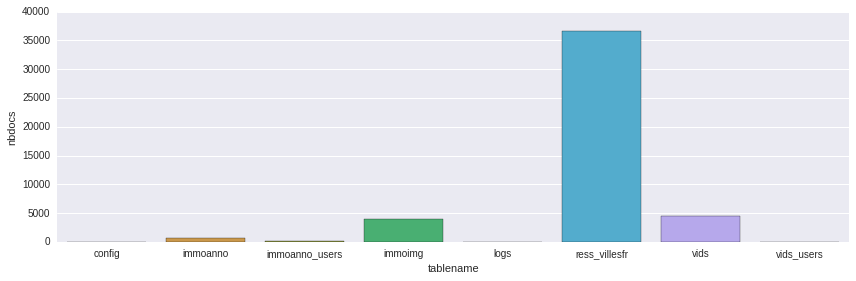

In [268]:
# Graph avec le default matplotlib : df_table_counts.plot(kind='bar')
# https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.factorplot.html#seaborn.factorplot
%pylab inline
import seaborn as sns
sns.set_style('darkgrid')
sns.factorplot(data=df_table_counts, x='tablename', y='nbdocs', kind="bar", aspect=3.0, order=list(df_table_counts.tablename))

## Query : recup sur config

In [353]:
print(r.table('config')['id'].distinct().run(rdb))

['check.requirements', 'deamon.monitor.rdb', 'deamon.scan.vifiles', 'fetch.imm.lbc', 'fetch.imm.sudi', 'fetch.imm.zil', 'fetcher.homwiz', 'ops4app', 'websrv.immo', 'websrv.static', 'websrv.vid']


In [357]:
list(r.table('config').filter(r.row['id'].match('fetch.imm.sudi')).run(rdb))

[{'id': 'fetch.imm.zil',
  'period.in.days': 2,
  'rdb.table.annonces': 'immoanno',
  'rdb.table.images': 'immoimg',
  'urls': {'bauges.73630': 'http://zilek.fr/immobilier/city/1/max_p-600000~trans_type-sale~property_type-house~sort-date/Doucy-en-Bauges%20(73630),Jarsy%20(73630),La%20Compôte%20(73630),Le%20Châtelard%20(73630).htm',
   'belledonne.73110': 'http://zilek.fr/immobilier/city/1/max_p-600000~trans_type-sale~property_type-house~sort-date/Bourget-en-Huile%20(73110),La%20Table%20(73110),Le%20Pontet%20(73110).htm',
   'belledonne.73220': 'http://zilek.fr/immobilier/city/1/max_p-600000~trans_type-sale~property_type-house~sort-date/Aiguebelle%20(73220),Bonvillaret%20(73220),Montsapey%20(73220).htm',
   'ecrins.38520': 'http://zilek.fr/immobilier/city/1/max_p-600000~radius-10~trans_type-sale~property_type-house~sort-date/Villard-Reymond%20(38520).htm',
   'monteynard.38350': 'http://zilek.fr/immobilier/city/1/max_p-600000~trans_type-sale~property_type-house~sort-date/Cognet%20(38350

In [358]:
r.table('config').get('fetch.imm.sudi').delete().run(rdb)

{'deleted': 1,
 'errors': 0,
 'inserted': 0,
 'replaced': 0,
 'skipped': 0,
 'unchanged': 0}